In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from load import get_measures
from load import load_data
from load import train_test_split
from matplotlib import rcParams
import plotly.express as px
import seaborn as sns

In [2]:
rcParams['figure.figsize'] = 15, 5

In [3]:
plt.style.use('fivethirtyeight') # estilo dos gráficos

In [4]:
# load models forecasts
df = pd.DataFrame()
for file in os.listdir("validation"):
    file_name = "validation/" + file
    df2 = pd.read_csv(file_name, index_col = "date")
    df2.columns = [file[:-7]]
    df = pd.concat([df, df2], axis = 1)

In [5]:
# load "actual" data
test = train_test_split(load_data(), 31)[1]
test.index = df.index
test.columns = ["test"]

In [6]:
df2 = pd.concat([df, test], axis = 1)

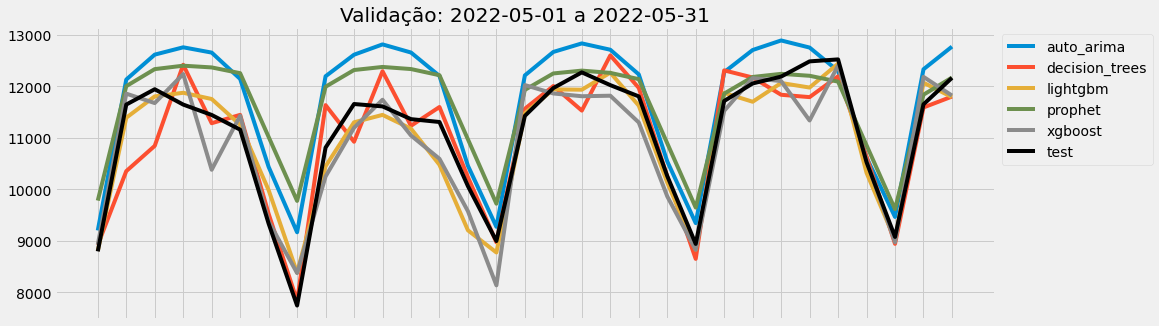

In [7]:
for model in df2.columns:
    if model == "test":
        continue
    plt.plot(df2[model], label = model)

plt.plot(df2["test"], c = "black", label = "test")

date_init = df2.index[0]
date_end = df2.index[-1]
plt.title(f"Validação: {date_init} a {date_end}")

frame1 = plt.gca()  # retirar valores do eixo x
frame1.axes.xaxis.set_ticklabels([])

plt.legend(bbox_to_anchor = (1,1)) # legenda na lateral direita

plt.show()

In [8]:
df3 = df2.reset_index().melt(id_vars = "date")
px.line(df3, x = "date", y = "value", color= "variable", title=f"Validação: {date_init} a {date_end}")

### Medidas de acurácia

In [9]:
dict_metrics = []
for model in df2.columns:
    # skips test column
    if model == "test":
        continue
    # for every model's forecast column
    else:
        # create a dict containing the accuracy measures
        measures = get_measures(df2[model], df2["test"])
        # create a column with the model name
        measures["model"] = model
        # append dictionary to list
        dict_metrics.append(measures)
# create dataframe from list of dicionaries
df2_metrics = pd.DataFrame(dict_metrics)   
# set the last column (model name) as the first one for a better view
temp_cols = df2_metrics.columns.to_list()
new_col_order = temp_cols[-1:] + temp_cols[:-1]
df2_metrics = df2_metrics[new_col_order]

In [10]:
df2_metrics.sort_values(by = "mape")

,model,erro,mae,mse,rmse,mape,smape
2,lightgbm,3.894151e+06,279.1693,125617.7876,354.4260,0.0260,2.6147
1,decision_trees,7.720546e+06,373.8243,249049.8674,499.0490,0.0327,3.2938
4,xgboost,7.073865e+06,380.3791,228189.1919,477.6915,0.0348,3.5340
3,prophet,1.851867e+07,618.5224,597376.3715,772.9013,0.0607,5.7684
0,auto_arima,1.940707e+07,703.8002,626034.5276,791.2234,0.0648,6.2193


In [11]:
df3_metrics = df2_metrics.melt(id_vars = "model", var_name="metric")
df3_metrics["metric_ranking"] = df3_metrics.groupby(["metric"])["value"].rank("first")
df3_metrics.sort_values(by = ["metric", "metric_ranking"], inplace = True)

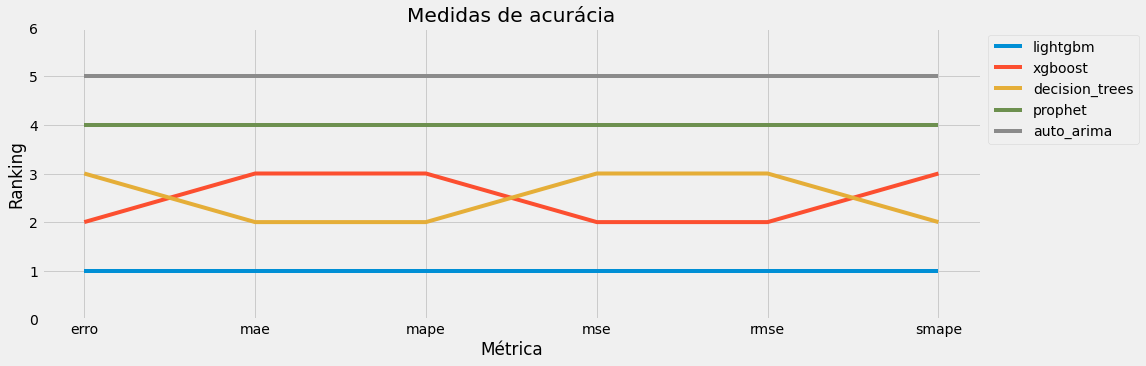

In [12]:
plt.figure()

ax = sns.lineplot(data=df3_metrics, x = "metric", y = "metric_ranking", hue="model")
ax.legend(bbox_to_anchor = (1,1))

plt.ylim(0, (df3_metrics["metric_ranking"].max()+1))
plt.ylabel("Ranking")
plt.xlabel("Métrica")
plt.title("Medidas de acurácia")
plt.show()

### Stacked Ensemble

In [13]:
# Criar combinação de todas colunas
import itertools
df_ensemble = df2.drop("test", axis = 1) # retira coluna de teste
ensemble_list = [x for x in df_ensemble.columns] # cria lista com o nome das colunas
combs = []
for r in range(1, len(df_ensemble.columns)+1):
    for comb in itertools.combinations(ensemble_list,r): # r: número de itens na combinação (de 1 a n-colunas)
        combs.append(list(comb))

In [14]:
# Criar dicionário com o as combinações
ensemble_dict = {}
for comb in combs:
    df_ensemble_subset =  df_ensemble[comb] # seleciona a combinação de colunas
    df_ensemble_cols = '-'.join(comb) # cria string com os nomes das colunas concatenados por '-'
    df_ensembled = df_ensemble_subset.mean(axis = 1) # média das colunas em T
    ensemble_dict[df_ensemble_cols] = df_ensembled # adiciona resultado ao dicionário

In [15]:
# Criar dataframe com MAPE de cada uma das combinações
ensemble_measures = []
for ensemble, series in ensemble_dict.items(): # tupla com o nome da chave e o conteúdo
    measure = get_measures(ensemble_dict[ensemble], df2["test"])["mape"] # obtém MAPE 
    new_line = {"ensemble": ensemble, "mape": measure} # ensemble: nome; measure: MAPE
    ensemble_measures.append(new_line)
df_ensemble_results =  pd.DataFrame(ensemble_measures).sort_values(by = "mape") # transforma lista de dicionários em DataFrame e ordena por MAPE
best_ensemble = df_ensemble_results.iloc[0,0] # seleciona modelo de menor MAPE
best_ensemble_series = ensemble_dict[best_ensemble]

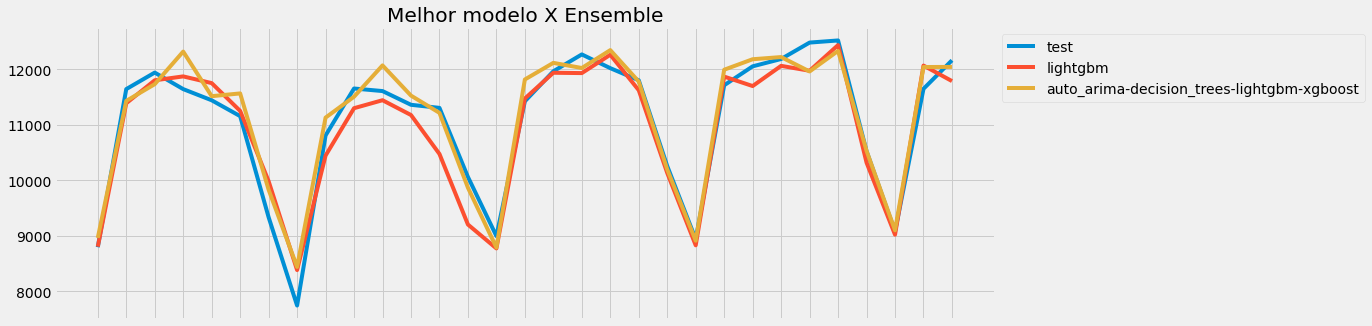

In [18]:
plt.plot(df2["test"], label = "test")

best_model = df2_metrics.sort_values(by="mape").reset_index().loc[0,"model"] # critério: MAPE
plt.plot(df2[best_model], label = best_model)

best_ensemble_series.index = df2["test"].index
plt.plot(best_ensemble_series, label = best_ensemble)

plt.title("Melhor modelo X Ensemble")
plt.legend(bbox_to_anchor = (1,1)) # legenda na lateral direita
frame1 = plt.gca()  # retirar valores do eixo x
frame1.axes.xaxis.set_ticklabels([])

plt.show()

In [21]:
print("MAPE modelo: ", df2_metrics.sort_values(by="mape").reset_index().loc[0,"mape"])
print("MAPE ensemble: ", df_ensemble_results.iloc[0,1])

MAPE modelo:  0.026
MAPE ensemble:  0.0223
